In [ ]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.datasets import fashion_mnist

Варіант 6. Побудувати CNN на основі ResNet-50 для класифікації зображень 
на основі датасету fashion-mnist.
Зробити налаштування моделі для досягнення необхідної точності. На базі
Siamese networks побудувати систему для пошуку подібних зображень в
датасеті fashion-mnist. Візуалізувати отримані результати t-SNE.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [ ]:
train_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

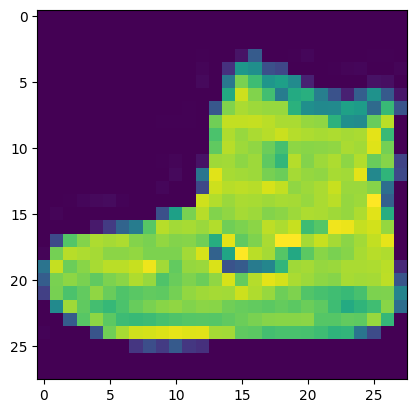

In [ ]:
plt.imshow(train_images[0])

In [ ]:
train_groups = [train_images[np.where(train_labels==i)[0]] for i in np.unique(train_labels)]
test_groups = [test_images[np.where(test_labels==i)[0]] for i in np.unique(train_labels)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

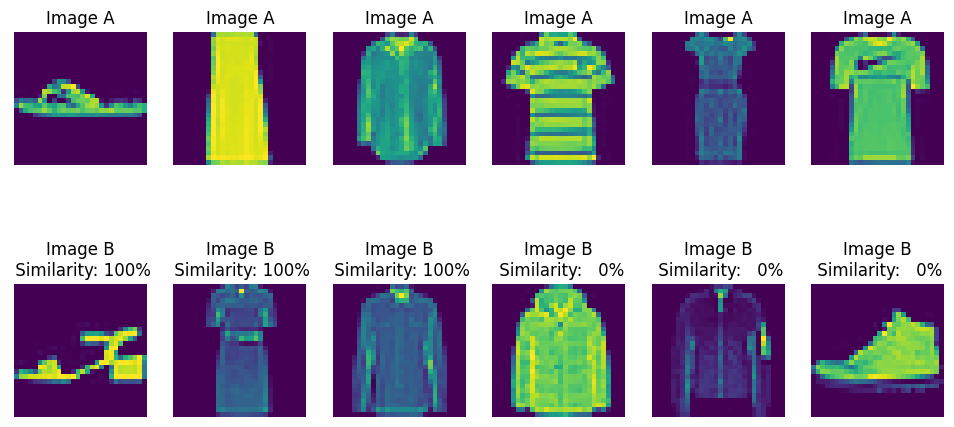

In [ ]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))

for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

img_in = Input(shape = train_images.shape[1:], name = 'FeatureNet_ImageInput')

### Building RESNET-50 

In [ ]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization  
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. we'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', 
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', 
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', 
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape, outputClasses):
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(outputClasses, activation='softmax', name='fc' + str(outputClasses), 
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
feature_model = ResNet50(train_images.shape[1:], 10)

In [ ]:
feature_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d_5 (ZeroPadding2  (None, 34, 34, 1)   0           ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 14, 14, 64)   3200        ['zero_padding2d_5[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 14, 14, 64)   256         ['conv1[0][0]']           

In [ ]:
feature_model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
feature_model.fit(train_images,
         train_labels,
         batch_size=64,
         epochs=10,
         validation_data=(test_images, test_labels))

Epoch 1/10
938/938 [==============================] - 87s 47ms/step - loss: 0.5517 - accuracy: 0.8050 - val_loss: 0.4367 - val_accuracy: 0.8415
Epoch 2/10
938/938 [==============================] - 43s 46ms/step - loss: 0.4310 - accuracy: 0.8485 - val_loss: 0.4200 - val_accuracy: 0.8439
Epoch 3/10
938/938 [==============================] - 43s 46ms/step - loss: 0.3508 - accuracy: 0.8771 - val_loss: 0.3525 - val_accuracy: 0.8676
Epoch 4/10
938/938 [==============================] - 41s 44ms/step - loss: 0.2978 - accuracy: 0.8930 - val_loss: 0.3447 - val_accuracy: 0.8761
Epoch 5/10
938/938 [==============================] - 42s 45ms/step - loss: 0.9121 - accuracy: 0.7391 - val_loss: 0.6061 - val_accuracy: 0.7891
Epoch 6/10
938/938 [==============================] - 42s 45ms/step - loss: 0.4807 - accuracy: 0.8271 - val_loss: 0.4228 - val_accuracy: 0.8410
Epoch 7/10
938/938 [==============================] - 41s 44ms/step - loss: 0.3698 - accuracy: 0.8636 - val_loss: 0.3737 - val_accuracy:

### Build siam network

In [ ]:
from keras.layers import concatenate


img_a_in = Input(shape = train_images.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = train_images.shape[1:], name = 'ImageB_Input')

img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)

combined_features = concatenate([img_a_feat, img_b_feat], name ='merge_features')
combined_features = Dense(100, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)

model = Model(inputs = [img_a_in, img_b_in], outputs =[combined_features], name = 'Similarity_Model')

model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ResNet50 (Functional)          (None, 10)           23601930    ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['ResNet50[0][0]',

In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

1/1 [==============================] - 2s 2s/step


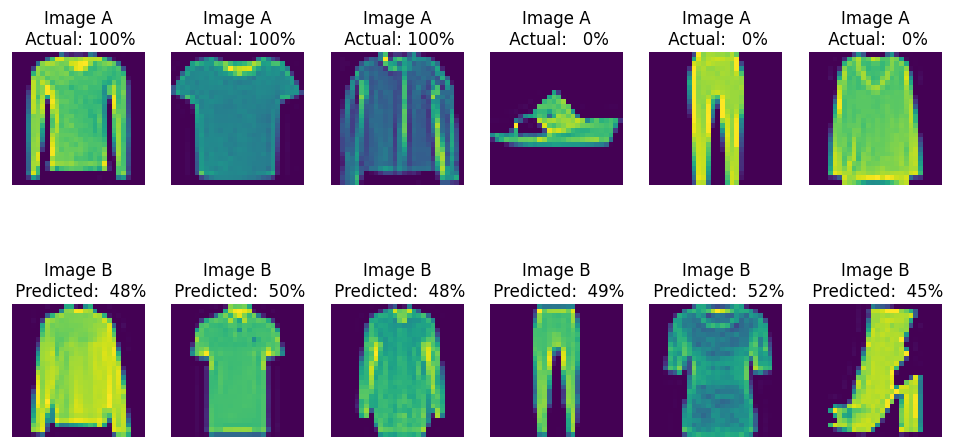

In [ ]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 64):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = model.fit_generator(siam_gen(train_groups), steps_per_epoch = 500, validation_data=([valid_a, valid_b], valid_sim), epochs = 10, verbose = True)


Epoch 1/10


<ipython-input-78-d949b532da25>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = model.fit_generator(siam_gen(train_groups), steps_per_epoch = 500, validation_data=([valid_a, valid_b], valid_sim), epochs = 10, verbose = True)


500/500 [==============================] - 95s 108ms/step - loss: 0.3667 - mae: 0.2501 - val_loss: 0.2668 - val_mae: 0.1750
Epoch 2/10
500/500 [==============================] - 51s 103ms/step - loss: 0.2402 - mae: 0.1516 - val_loss: 0.2391 - val_mae: 0.1452
Epoch 3/10
500/500 [==============================] - 52s 104ms/step - loss: 0.2179 - mae: 0.1346 - val_loss: 0.2028 - val_mae: 0.1230
Epoch 4/10
500/500 [==============================] - 51s 101ms/step - loss: 0.2027 - mae: 0.1232 - val_loss: 0.1991 - val_mae: 0.1128
Epoch 5/10
500/500 [==============================] - 52s 104ms/step - loss: 0.2413 - mae: 0.1457 - val_loss: 0.2376 - val_mae: 0.1422
Epoch 6/10
500/500 [==============================] - 53s 106ms/step - loss: 0.2199 - mae: 0.1342 - val_loss: 0.2209 - val_mae: 0.1269
Epoch 7/10
500/500 [==============================] - 52s 103ms/step - loss: 0.2035 - mae: 0.1237 - val_loss: 0.2042 - val_mae: 0.1255
Epoch 8/10
500/500 [==============================] - 51s 103ms/st

In [ ]:
# save
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model_save_name = "similarity_model"
path = f"/content/drive/MyDrive/nulp_cv/{model_save_name}"
model.save(path)

1/1 [==============================] - 0s 44ms/step


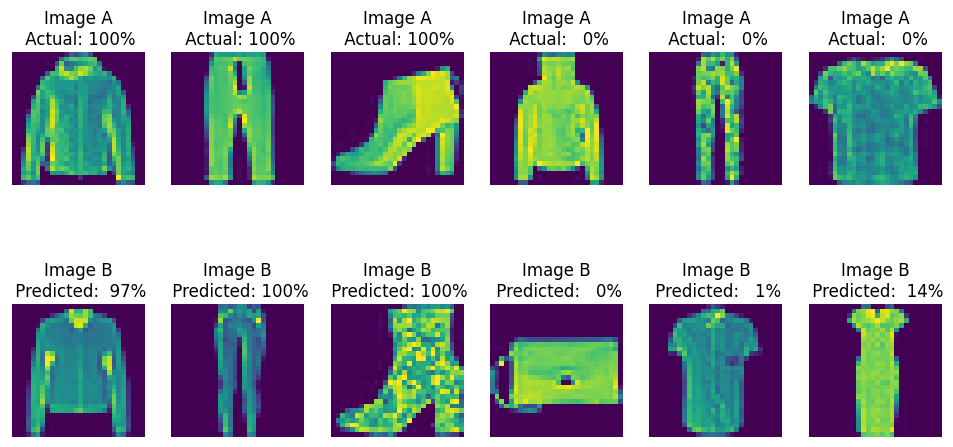

In [ ]:
_ = show_model_output()

In [ ]:
%%time
x_test_features = feature_model.predict(test_images, verbose = True, batch_size=128)

79/79 [==============================] - 2s 13ms/step
CPU times: user 2.09 s, sys: 53.3 ms, total: 2.15 s
Wall time: 2.24 s


In [ ]:
from sklearn.manifold import TSNE

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 0.412s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.591888
[t-SNE] KL divergence after 500 iterations: 1.037041


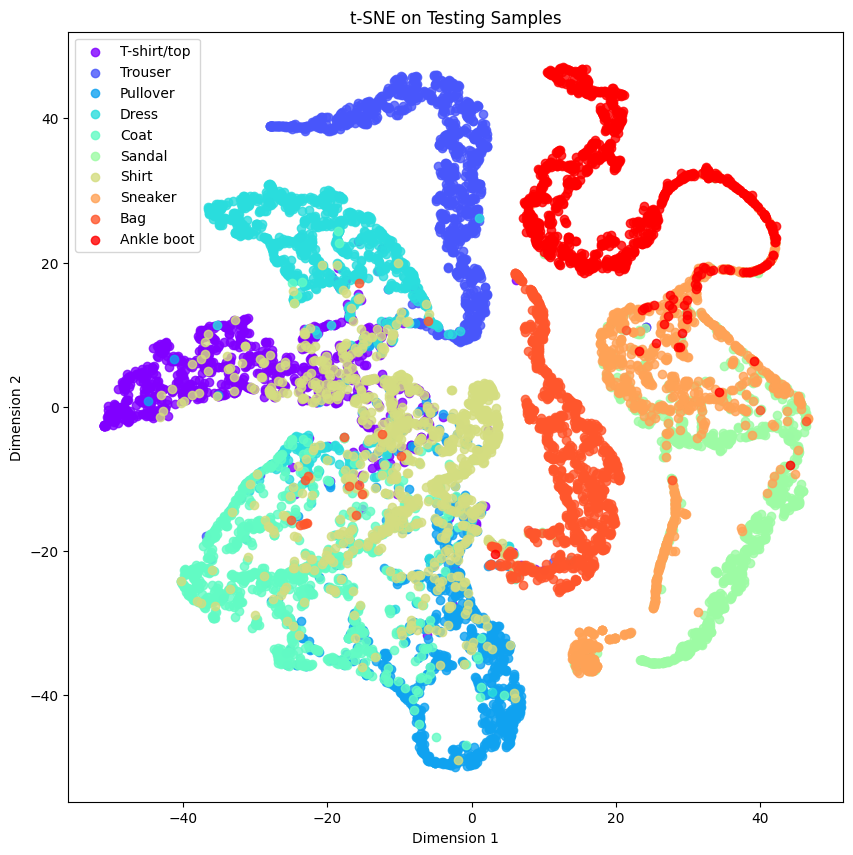

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(test_labels == c_group), 0],
                tsne_features[np.where(test_labels == c_group), 1],
                marker='o',
                color=c_color,
                linewidth=1,
                alpha=0.8,
                label=c_label)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show(block=False)